In [2]:
import liftout

from liftout.fibsem import acquire, calibration
from autoscript_sdb_microscope_client.structures import AdornedImage

import pandas as pd

## Cross Correlation Tuning

In [ ]:

img1 = AdornedImage.load("crosscorrelation_1_ib.tif")
img2 = AdornedImage.load("crosscorrelation_2_ib.tif")

target_dx, target_dy = 2e-6, -5e-6


lp_values = [8, 16, 32, 64, 128, 256]
hp_values = [1.5, 3, 6, 12, 24, 48]
sigma_values = [2.5, 5, 10, 20, 45]


df = pd.DataFrame()
from tqdm.notebook import tqdm

n_exp = len(lp_values) * len(hp_values) * len(sigma_values)
pbar = tqdm(total=n_exp)

counter = 0
for i, lp in enumerate(lp_values):
    for j, hp in enumerate(hp_values):
        for k, sigma in enumerate(sigma_values):
            
            if hp > lp:
                continue
            frac=(counter / n_exp)
#             print(counter, frac)
#             print(counter)
#             pbar.update(counter)
            pbar.set_description(f"EXP {counter}/{n_exp}: ({lp}, {hp}, {sigma})")
                        
            dx, dy = calibration.shift_from_crosscorrelation_AdornedImages(
                img1, img2, lowpass=lp, highpass=hp, sigma=sigma, use_rect_mask=True)

#             print(f"{lp}, {hp}, {sigma}, {dx:.3e}, {dy:.3e} {abs(dx - target_dx):.3e}, {abs(dy - target_dy):.3e}")
            
            record = {"lp": lp, "hp": hp, "sigma": sigma, "dx": dx, "dy": dy, "target_dx": target_dx, "target_dy": target_dy}

            df = df.append(record, ignore_index=True)
            counter+=1

pbar.close()

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)


df["d_dx"] = abs(df["dx"] - df["target_dx"])
df["d_dy"] = abs(df["dy"] - df["target_dy"])
df["delta"] = df["d_dx"] + df["d_dy"] * 1e7
print(df.sort_values(["delta", "d_dx", "d_dy"]).head(50))



In [ ]:
import plotly.graph_objects as go
import datetime
import numpy as np

fig = go.Figure(data=go.Heatmap(
        z=df["delta"],
        x=df["lp"],
        y=df["hp"]))


fig.update_layout(
    title='Distance from target value')

fig.show()


fig = go.Figure(data=go.Heatmap(
        z=df["delta"],
        x=df["lp"],
        y=df["sigma"]))


fig.update_layout(
    title='Distance from target value')

fig.show()

In [ ]:
#     aligned = np.copy(image_1)
#     aligned = np.roll(aligned, +int(shift_01_x), axis=0)
#     aligned = np.roll(aligned, +int(shift_01_y), axis=1)
#     aligned_smooth = ndi.filters.gaussian_filter( aligned, sigma=3)

pixelsize_x = img1.metadata.binary_result.pixel_size.x

dx = 1.693e-06
dy = -4.329e-06

dx_pixels = -dx / pixelsize_x
dy_pixels = -dy   / pixelsize_x  

print(pixelsize_x)
print(dx_pixels, dy_pixels)
aligned = np.copy(img2.data)
aligned = np.roll(aligned, int(dy_pixels), axis=0)
aligned = np.roll(aligned, int(dx_pixels), axis=1)
                      
import matplotlib.pyplot as plt

plt.figure(1, figsize=(20, 20))
plt.subplot(2,2,1)
plt.title('image 1,2: overlay')
plt.imshow( img1.data[200:, :-100], cmap='Blues_r',   alpha=0.5)
plt.imshow( img2.data[200:, :-100], cmap='Oranges_r', alpha=0.5)
plt.subplot(2,2,2)
plt.title('image 1 shifted to align with 2')
plt.imshow( img1.data[200:, :-100], cmap='Blues_r',   alpha=0.5)
plt.imshow( aligned[200:, :-100], cmap='Oranges_r', alpha=0.5)




# cross products
# print(img1.data.shape)
# ret_1 = np.cross(img1.data, img2.data.T)
# # ret_2 = np.cross(img1.data, aligned.T)

# print(ret_1)
# print(ret_2)


# import cv2
# from skimage import compare_ssim

from skimage.metrics import structural_similarity
# img = cv2.imread('img_1.png')
# img_2 = cv2.imread('img_2.png')

print(structural_similarity(img1.data[200:, :-100], img2.data[200:, :-100]))
print(structural_similarity(img1.data[200:, :-100], aligned[200:, :-100]))

In [ ]:

lp_values = [8, 64, 256]
hp_values = [1.5, 12, 48]
sigma_values = [2.5,10, 45]

for i, lp in enumerate(lp_values):
    for j, hp in enumerate(hp_values):
        for k, sigma in enumerate(sigma_values):

            
            if hp> lp: 
                continue
            highpass, lowpass, sigma = hp, lp, sigma
            use_rect_mask = True
            img1_data_norm = (img1.data - np.mean(img1.data)) / np.std(img1.data)
            img2_data_norm = (img2.data - np.mean(img2.data)) / np.std(img2.data)
            # cross-correlate normalised images
            if use_rect_mask:
                rect_mask = calibration._mask_rectangular(img2_data_norm.shape)
                img1_data_norm = rect_mask * img1_data_norm
                img2_data_norm = rect_mask * img2_data_norm
            xcorr = calibration.crosscorrelation(
                img1_data_norm, img2_data_norm, bp="yes", lp=lowpass, hp=highpass, sigma=sigma
            )
            
            print(lp, hp, sigma, np.max(xcorr), np.unravel_index(np.argmax(xcorr), xcorr.shape))
#             print(xcorr)
#             print(xcorr.shape)

            plt.imshow(xcorr)
            plt.show()

## New CrossCorrelation

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:

import liftout

from liftout.fibsem import acquire, calibration
from autoscript_sdb_microscope_client.structures import AdornedImage

import pandas as pd
import numpy as np
from scipy import fftpack, misc
import matplotlib.pyplot as plt
img1 = AdornedImage.load(r"C:\Users\Admin\Github\autoliftout\liftout\log\run\20220107.113142\img/01_ib_drift_correction_lamella_low_res_0_eb.tif")
img2 = AdornedImage.load(r"C:\Users\Admin\Github\autoliftout\liftout\log\run\20220107.113142\img/01_ref_trench_low_res_ib.tif")
# dx, dy = calibration.shift_from_correlation_electronBeam_and_ionBeam(img1, img2)



# def crosscorrelation2(img1, img2, bp="no", *args, **kwargs):
#     if img1.shape != img2.shape:
#         logging.error(
#             "### ERROR in xcorr2: img1 and img2 do not have the same size ###"
#         )
#         return -1
#     if img1.dtype != "float64":
#         img1 = np.array(img1, float)
#     if img2.dtype != "float64":
#         img2 = np.array(img2, float)

#     if bp == "yes":
#         lpv = kwargs.get("lp", None)
#         hpv = kwargs.get("hp", None)
#         sigmav = kwargs.get("sigma", None)
#         if lpv == "None" or hpv == "None" or sigmav == "None":
#             logging.error("ERROR in xcorr2: check bandpass parameters")
#             return -1
#         bandpass = calibration.bandpass_mask(
#             size=(img1.shape[1], img1.shape[0]), lp=lpv, hp=hpv, sigma=sigmav
#         )
#         img1ft = fftpack.ifftshift(bandpass * fftpack.fftshift(fftpack.fft2(img1)))
#         s = img1.shape[0] * img1.shape[1]
#         tmp = img1ft * np.conj(img1ft)
#        # img1ft = s * img1ft / np.sqrt(tmp.sum())
#         img2ft = fftpack.ifftshift(bandpass * fftpack.fftshift(fftpack.fft2(img2)))
#         img2ft[0, 0] = 0
#         tmp = img2ft * np.conj(img2ft)
#        # img2ft = s * img2ft / np.sqrt(tmp.sum())
#         xcorr = np.real(fftpack.fftshift(fftpack.ifft2(img1ft * np.conj(img2ft))))
        
#         f_img1 = fftpack.ifft2(img1ft)
#     elif bp == "no":
#         img1ft = fftpack.fft2(img1)
#         img2ft = np.conj(fftpack.fft2(img2))
#         img1ft[0, 0] = 0
#         xcorr = np.abs(fftpack.fftshift(fftpack.ifft2(img1ft * img2ft)))
#     else:
#         logging.error(
#             "ERROR in xcorr2: bandpass value ( bp= " + str(bp) + " ) not recognized"
#         )
#         return -1
#     return xcorr, f_img1



# lowpass = int(max(img1.data.shape) * 0.66)   # =128 @ 1536x1024, good for e-beam images
# highpass = 6
# sigma = 3
# use_rect_mask = True
# img1_data_norm = (img1.data - np.mean(img1.data)) / np.std(img1.data)
# img2_data_norm = (img2.data - np.mean(img2.data)) / np.std(img2.data)
# # cross-correlate normalised images
# if use_rect_mask:
#     rect_mask = calibration._mask_rectangular(image_shape=img2_data_norm.shape, sigma=15.0)
#     img1_data_norm = rect_mask * img1_data_norm
#     img2_data_norm = rect_mask * img2_data_norm
# xcorr, f_img1 = crosscorrelation2(
#     img1_data_norm, img2_data_norm, bp="yes", lp=lowpass, hp=highpass, sigma=sigma
# )

# print(lowpass, highpass, sigma, np.max(xcorr), np.unravel_index(np.argmax(xcorr), xcorr.shape))

# plt.figure(figsize=(10, 10))
# plt.imshow(fftpack.fftshift(xcorr))
# plt.show()

# plt.imshow(np.real(f_img1))
# plt.show()
# plt.figure(figsize=(10, 10))

# plt.imshow(img2_data_norm+(img1_data_norm))
# plt.show()

# maxX, maxY = np.unravel_index(np.argmax(fftpack.fftshift(xcorr)), xcorr.shape)
# cen = np.asarray(xcorr.shape) / 2
# err = np.array(cen - [maxX, maxY], int)
# x_shift = err[1] * img1.metadata.binary_result.pixel_size.x
# y_shift = err[0] * img1.metadata.binary_result.pixel_size.x

# dx, dy = x_shift, y_shift

# print(maxX, maxY)
# print(dx, dy)


# # img1_rot = calibration.rotate_AdornedImage(img1)

# import matplotlib.pyplot as plt
# # plt.imshow(calibration.rotate_AdornedImage(img2).data, cmap="gray")
# plt.show()
# plt.imshow(img1.data, cmap="gray")
# plt.show()



In [19]:
rect_mask, sigma=10:   -0.000159375204 -7.187509200000001e-05

SyntaxError: invalid syntax (<ipython-input-19-2d24b0c04993>, line 1)

1013 6 3 84004.11002715652 (276, 612)


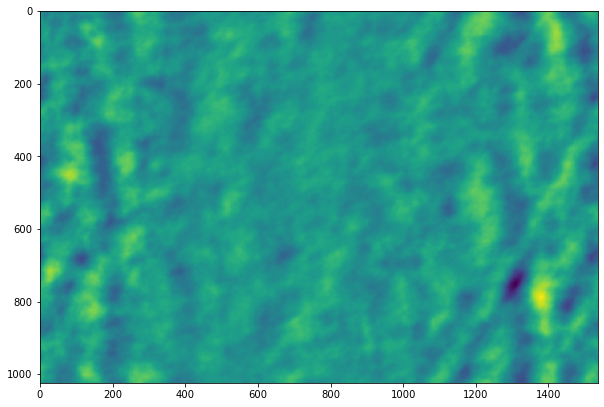

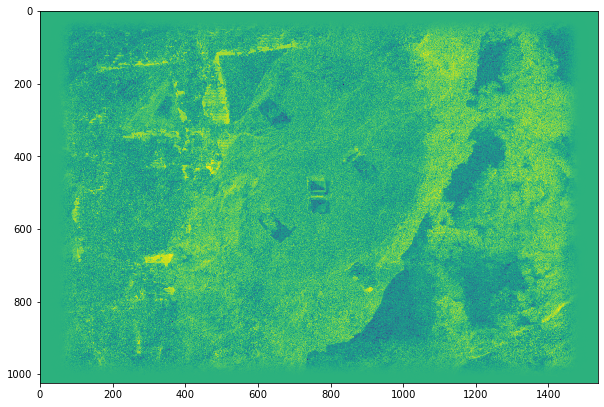

276 612
4.0625052e-05 6.1458412e-05


In [26]:

lowpass = int(max(img1.data.shape) * 0.66)   # =128 @ 1536x1024, good for e-beam images
highpass = 6
sigma = 3
use_rect_mask = True
img1_data_norm = (img1.data - np.mean(img1.data)) / np.std(img1.data)
img2_data_norm = (img2.data - np.mean(img2.data)) / np.std(img2.data)
# cross-correlate normalised images
if use_rect_mask:
    rect_mask = calibration._mask_rectangular(image_shape=img2_data_norm.shape, sigma=15.0)
    img2_data_norm = rect_mask * img2_data_norm
xcorr= calibration.crosscorrelation(
    img1_data_norm, img2_data_norm, bp="yes", lp=lowpass, hp=highpass, sigma=sigma
)

print(lowpass, highpass, sigma, np.max(xcorr), np.unravel_index(np.argmax(xcorr), xcorr.shape))

plt.figure(figsize=(10, 10))
plt.imshow(fftpack.fftshift(xcorr))
plt.show()

# plt.imshow(np.real(f_img1))
# plt.show()
plt.figure(figsize=(10, 10))

plt.imshow(img2_data_norm+(img1_data_norm))
plt.show()

maxX, maxY = np.unravel_index(np.argmax(xcorr), xcorr.shape)
cen = np.asarray(xcorr.shape) / 2
err = np.array(cen - [maxX, maxY], int)
x_shift = err[1] * img1.metadata.binary_result.pixel_size.x
y_shift = err[0] * img1.metadata.binary_result.pixel_size.x

dx, dy = x_shift, y_shift

print(maxX, maxY)
print(dx, dy)


# img1_rot = calibration.rotate_AdornedImage(img1)

import matplotlib.pyplot as plt
# plt.imshow(calibration.rotate_AdornedImage(img2).data, cmap="gray")
# plt.show()
# plt.imshow(img1.data, cmap="gray")
# plt.show()
